In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from PIL import Image
import mtcnn
from mtcnn.mtcnn import MTCNN
from os import listdir
from os.path import isdir
import cv2
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import random
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.utils import to_categorical
from keras.regularizers import l1, l2, l1_l2
from keras.optimizers import Adam, SGD, RMSprop, Adamax
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


In [3]:
print(tf.__version__)
print(keras.__version__)
print(mtcnn.__version__)

2.1.0
2.3.1
0.1.0


In [4]:
facenet = load_model('facenet_keras.h5')
print(facenet.inputs)
print(facenet.outputs)

[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/cond/Identity:0' shape=(None, 128) dtype=float32>]


C:\Users\synre\anaconda3\envs\allsort\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
twice = np.load('twice_compressed.npz')
X_train, y_train = twice['X_train'], twice['y_train']

In [6]:
print(X_train.shape), print(y_train.shape)

(5136, 160, 160, 3)
(5136,)


(None, None)

In [7]:
twice_test = np.load('twice_test.npz')
X_test, y_test = twice_test['X_test'], twice_test['y_test']

In [8]:
print(X_test.shape), print(y_test.shape)

(109, 160, 160, 3)
(109,)


(None, None)

In [9]:
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis=0)
    y_hat = model.predict(samples)
    return y_hat[0]

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=29, stratify=y_train)

In [11]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(3852, 160, 160, 3)
(1284, 160, 160, 3)
(3852,)
(1284,)


In [12]:
X_train_emb = list()
for face in X_train:
    embedding = get_embedding(facenet, face)
    X_train_emb.append(embedding)

X_train_emb = np.asarray(X_train_emb)
print(X_train_emb.shape)

(3852, 128)


In [13]:
X_val_emb = list()
for face in X_val:
    embedding = get_embedding(facenet, face)
    X_val_emb.append(embedding)

X_val_emb = np.asarray(X_val_emb)
print(X_val_emb.shape)

(1284, 128)


In [14]:
in_encoder = Normalizer(norm='l2')

In [15]:
X_train_norm = in_encoder.fit_transform(X_train_emb)
X_val_norm = in_encoder.transform(X_val_emb)

In [16]:
out_encoder = LabelEncoder()
out_encoder.fit(y_train)
y_train_label = out_encoder.transform(y_train)
y_val_label = out_encoder.transform(y_val)

In [17]:
y_train_label

array([2, 8, 3, ..., 4, 7, 0])

In [18]:
y_train_hot = to_categorical(y_train_label)
y_val_hot = to_categorical(y_val_label)

In [19]:
print(X_train_norm.shape), print(y_train_hot.shape)

(3852, 128)
(3852, 9)


(None, None)

In [20]:
print(X_val_norm.shape), print(y_val_hot.shape)

(1284, 128)
(1284, 9)


(None, None)

In [21]:
X_test_emb = list()
for face in X_test:
    embedding = get_embedding(facenet, face)
    X_test_emb.append(embedding)

X_test_emb = np.asarray(X_test_emb)
print(X_test_emb.shape)

(109, 128)


In [22]:
X_test_norm = in_encoder.fit_transform(X_test_emb)
y_test_label = out_encoder.transform(y_test)
y_test_hot = to_categorical(y_test_label)

In [23]:
print(X_test_norm.shape), print(y_test_hot.shape)

(109, 128)
(109, 9)


(None, None)

In [24]:
callbacks = EarlyStopping(monitor='val_accuracy', mode='max', patience=50, verbose=1)

In [25]:
model_2 = Sequential([
    Dense(16, input_shape=(128, ), activation='selu', kernel_initializer='lecun_normal'),    
    Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.05)),
    Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.03)),
    Dropout((0.3)),
    Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.03)),
    Dropout((0.3)),
    Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.03)),
    Dropout((0.5)),
    Dense(9, activation='softmax')
])


model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

In [26]:
history_2 = model_2.fit(x=X_train_norm, y=y_train_hot, batch_size=16, epochs=600, verbose=1,
                        validation_data=(X_val_norm, y_val_hot), callbacks=[callbacks])

Train on 3852 samples, validate on 1284 samples
Epoch 1/600
3852/3852 [==============================] - 1s 292us/step - loss: 12.5362 - accuracy: 0.3606 - val_loss: 4.8542 - val_accuracy: 0.5249
Epoch 2/600
3852/3852 [==============================] - 1s 227us/step - loss: 3.2327 - accuracy: 0.5273 - val_loss: 2.1955 - val_accuracy: 0.5631
Epoch 3/600
3852/3852 [==============================] - 1s 240us/step - loss: 1.9310 - accuracy: 0.5657 - val_loss: 1.6218 - val_accuracy: 0.6223
Epoch 4/600
3852/3852 [==============================] - 1s 239us/step - loss: 1.6276 - accuracy: 0.5805 - val_loss: 1.4761 - val_accuracy: 0.6067
Epoch 5/600
3852/3852 [==============================] - 1s 237us/step - loss: 1.5184 - accuracy: 0.5857 - val_loss: 1.4125 - val_accuracy: 0.6176
Epoch 6/600
3852/3852 [==============================] - 1s 244us/step - loss: 1.4737 - accuracy: 0.5935 - val_loss: 1.3326 - val_accuracy: 0.6565
Epoch 7/600
3852/3852 [==============================] - 1s 239us/ste

3852/3852 [==============================] - 1s 242us/step - loss: 0.9939 - accuracy: 0.7921 - val_loss: 0.9014 - val_accuracy: 0.8255
Epoch 57/600
3852/3852 [==============================] - 1s 243us/step - loss: 0.9815 - accuracy: 0.7975 - val_loss: 0.8954 - val_accuracy: 0.8224
Epoch 58/600
3852/3852 [==============================] - 1s 244us/step - loss: 0.9832 - accuracy: 0.7944 - val_loss: 0.9407 - val_accuracy: 0.8224
Epoch 59/600
3852/3852 [==============================] - 1s 235us/step - loss: 0.9715 - accuracy: 0.7980 - val_loss: 0.8999 - val_accuracy: 0.8310
Epoch 60/600
3852/3852 [==============================] - 1s 242us/step - loss: 0.9591 - accuracy: 0.8079 - val_loss: 0.8784 - val_accuracy: 0.8310
Epoch 61/600
3852/3852 [==============================] - 1s 243us/step - loss: 0.9592 - accuracy: 0.8045 - val_loss: 0.9039 - val_accuracy: 0.8240
Epoch 62/600
3852/3852 [==============================] - 1s 238us/step - loss: 0.9620 - accuracy: 0.8087 - val_loss: 0.8747 

3852/3852 [==============================] - 1s 249us/step - loss: 0.6849 - accuracy: 0.9019 - val_loss: 0.6723 - val_accuracy: 0.9050
Epoch 167/600
3852/3852 [==============================] - 1s 270us/step - loss: 0.6741 - accuracy: 0.9065 - val_loss: 0.6529 - val_accuracy: 0.9151
Epoch 168/600
3852/3852 [==============================] - 1s 240us/step - loss: 0.6702 - accuracy: 0.9024 - val_loss: 0.6836 - val_accuracy: 0.9081
Epoch 169/600
3852/3852 [==============================] - 1s 237us/step - loss: 0.6637 - accuracy: 0.9021 - val_loss: 0.6718 - val_accuracy: 0.9050
Epoch 170/600
3852/3852 [==============================] - 1s 248us/step - loss: 0.6626 - accuracy: 0.8972 - val_loss: 0.6524 - val_accuracy: 0.9081
Epoch 171/600
3852/3852 [==============================] - 1s 239us/step - loss: 0.6440 - accuracy: 0.9068 - val_loss: 0.6373 - val_accuracy: 0.9143
Epoch 172/600
3852/3852 [==============================] - 1s 238us/step - loss: 0.6636 - accuracy: 0.9006 - val_loss: 0

3852/3852 [==============================] - 1s 235us/step - loss: 0.6133 - accuracy: 0.9154 - val_loss: 0.6200 - val_accuracy: 0.9198
Epoch 222/600
3852/3852 [==============================] - 1s 236us/step - loss: 0.6120 - accuracy: 0.9172 - val_loss: 0.6459 - val_accuracy: 0.9112
Epoch 223/600
3852/3852 [==============================] - 1s 241us/step - loss: 0.6198 - accuracy: 0.9130 - val_loss: 0.6560 - val_accuracy: 0.9151
Epoch 224/600
3852/3852 [==============================] - 1s 239us/step - loss: 0.6256 - accuracy: 0.9120 - val_loss: 0.6420 - val_accuracy: 0.9174
Epoch 225/600
3852/3852 [==============================] - 1s 240us/step - loss: 0.6125 - accuracy: 0.9180 - val_loss: 0.6400 - val_accuracy: 0.9159
Epoch 226/600
3852/3852 [==============================] - 1s 235us/step - loss: 0.6094 - accuracy: 0.9154 - val_loss: 0.6338 - val_accuracy: 0.9206
Epoch 227/600
3852/3852 [==============================] - 1s 238us/step - loss: 0.6146 - accuracy: 0.9115 - val_loss: 0

3852/3852 [==============================] - 1s 230us/step - loss: 0.5711 - accuracy: 0.9250 - val_loss: 0.6181 - val_accuracy: 0.9206
Epoch 277/600
3852/3852 [==============================] - 1s 240us/step - loss: 0.5603 - accuracy: 0.9239 - val_loss: 0.6545 - val_accuracy: 0.9167
Epoch 278/600
3852/3852 [==============================] - 1s 228us/step - loss: 0.5616 - accuracy: 0.9224 - val_loss: 0.6129 - val_accuracy: 0.9206
Epoch 279/600
3852/3852 [==============================] - 1s 227us/step - loss: 0.5693 - accuracy: 0.9271 - val_loss: 0.6174 - val_accuracy: 0.9283
Epoch 280/600
3852/3852 [==============================] - 1s 237us/step - loss: 0.5611 - accuracy: 0.9289 - val_loss: 0.6166 - val_accuracy: 0.9190
Epoch 281/600
3852/3852 [==============================] - 1s 235us/step - loss: 0.5710 - accuracy: 0.9232 - val_loss: 0.6156 - val_accuracy: 0.9167
Epoch 282/600
3852/3852 [==============================] - 1s 224us/step - loss: 0.5707 - accuracy: 0.9200 - val_loss: 0

3852/3852 [==============================] - 1s 241us/step - loss: 0.5027 - accuracy: 0.9413 - val_loss: 0.5775 - val_accuracy: 0.9291
Epoch 386/600
3852/3852 [==============================] - 1s 241us/step - loss: 0.5084 - accuracy: 0.9413 - val_loss: 0.6076 - val_accuracy: 0.9252
Epoch 387/600
3852/3852 [==============================] - 1s 277us/step - loss: 0.5093 - accuracy: 0.9374 - val_loss: 0.6132 - val_accuracy: 0.9268
Epoch 388/600
3852/3852 [==============================] - 1s 242us/step - loss: 0.4985 - accuracy: 0.9390 - val_loss: 0.6041 - val_accuracy: 0.9283
Epoch 389/600
3852/3852 [==============================] - 1s 242us/step - loss: 0.4996 - accuracy: 0.9426 - val_loss: 0.5998 - val_accuracy: 0.9299
Epoch 390/600
3852/3852 [==============================] - 1s 243us/step - loss: 0.5019 - accuracy: 0.9356 - val_loss: 0.5798 - val_accuracy: 0.9291
Epoch 391/600
3852/3852 [==============================] - 1s 238us/step - loss: 0.4945 - accuracy: 0.9393 - val_loss: 0

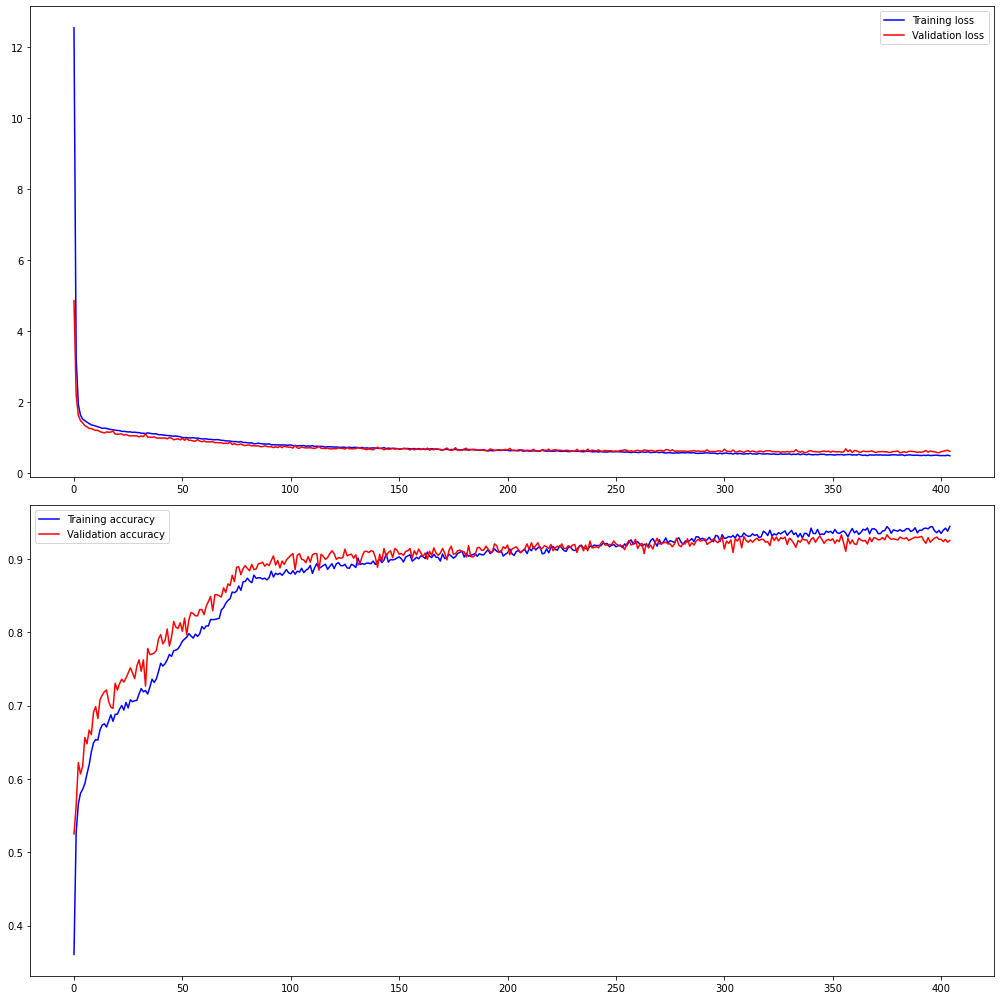

In [27]:
plt.figure(figsize=(14,14))

plt.subplot(2,1,1)
plt.plot(history_2.history['loss'], color='blue', label='Training loss')
plt.plot(history_2.history['val_loss'], color='red', label='Validation loss')
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.plot(history_2.history['accuracy'], color='blue', label='Training accuracy')
plt.plot(history_2.history['val_accuracy'], color='red', label='Validation accuracy')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [28]:
model_2.evaluate(X_test_norm, y_test_hot, verbose=1)

109/109 [==============================] - 0s 106us/step


[0.659887068862215, 0.9174311757087708]

In [29]:
model_3 = Sequential([
    Dense(256, input_shape=(128, ), activation='relu', kernel_initializer='he_normal', activity_regularizer=l2(0.05)),
    Dropout((0.5)),
    Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    Dense(9, activation='softmax')
])

opt = keras.optimizers.Adam(learning_rate=0.0003)

model_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 9)                 1161      
Total params: 67,081
Trainable params: 67,081
Non-trainable params: 0
_________________________________________________________________


In [30]:
history_3 = model_3.fit(x=X_train_norm, y=y_train_hot, batch_size=16, epochs=300, verbose=2,
                        validation_data=(X_val_norm, y_val_hot), callbacks=[callbacks])

Train on 3852 samples, validate on 1284 samples
Epoch 1/300
 - 1s - loss: 4.0334 - accuracy: 0.2578 - val_loss: 2.9981 - val_accuracy: 0.2438
Epoch 2/300
 - 1s - loss: 2.5868 - accuracy: 0.2505 - val_loss: 2.2624 - val_accuracy: 0.2866
Epoch 3/300
 - 1s - loss: 2.0509 - accuracy: 0.3990 - val_loss: 1.8297 - val_accuracy: 0.4626
Epoch 4/300
 - 1s - loss: 1.7203 - accuracy: 0.6184 - val_loss: 1.5302 - val_accuracy: 0.8076
Epoch 5/300
 - 1s - loss: 1.4877 - accuracy: 0.7915 - val_loss: 1.2880 - val_accuracy: 0.9120
Epoch 6/300
 - 1s - loss: 1.3180 - accuracy: 0.8512 - val_loss: 1.1433 - val_accuracy: 0.9206
Epoch 7/300
 - 1s - loss: 1.2105 - accuracy: 0.8707 - val_loss: 1.0551 - val_accuracy: 0.9252
Epoch 8/300
 - 1s - loss: 1.1434 - accuracy: 0.8881 - val_loss: 0.9944 - val_accuracy: 0.9315
Epoch 9/300
 - 1s - loss: 1.0872 - accuracy: 0.8904 - val_loss: 0.9510 - val_accuracy: 0.9330
Epoch 10/300
 - 1s - loss: 1.0447 - accuracy: 0.8907 - val_loss: 0.9103 - val_accuracy: 0.9354
Epoch 11/30

Epoch 87/300
 - 1s - loss: 0.5578 - accuracy: 0.9330 - val_loss: 0.5043 - val_accuracy: 0.9463
Epoch 88/300
 - 1s - loss: 0.5640 - accuracy: 0.9343 - val_loss: 0.5013 - val_accuracy: 0.9470
Epoch 89/300
 - 1s - loss: 0.5670 - accuracy: 0.9361 - val_loss: 0.5031 - val_accuracy: 0.9470
Epoch 90/300
 - 1s - loss: 0.5629 - accuracy: 0.9359 - val_loss: 0.4989 - val_accuracy: 0.9494
Epoch 91/300
 - 1s - loss: 0.5624 - accuracy: 0.9351 - val_loss: 0.5019 - val_accuracy: 0.9478
Epoch 92/300
 - 1s - loss: 0.5607 - accuracy: 0.9367 - val_loss: 0.4979 - val_accuracy: 0.9486
Epoch 93/300
 - 1s - loss: 0.5524 - accuracy: 0.9408 - val_loss: 0.4944 - val_accuracy: 0.9502
Epoch 94/300
 - 1s - loss: 0.5479 - accuracy: 0.9328 - val_loss: 0.4931 - val_accuracy: 0.9470
Epoch 95/300
 - 1s - loss: 0.5463 - accuracy: 0.9359 - val_loss: 0.4958 - val_accuracy: 0.9470
Epoch 96/300
 - 1s - loss: 0.5315 - accuracy: 0.9439 - val_loss: 0.4930 - val_accuracy: 0.9486
Epoch 97/300
 - 1s - loss: 0.5454 - accuracy: 0.94

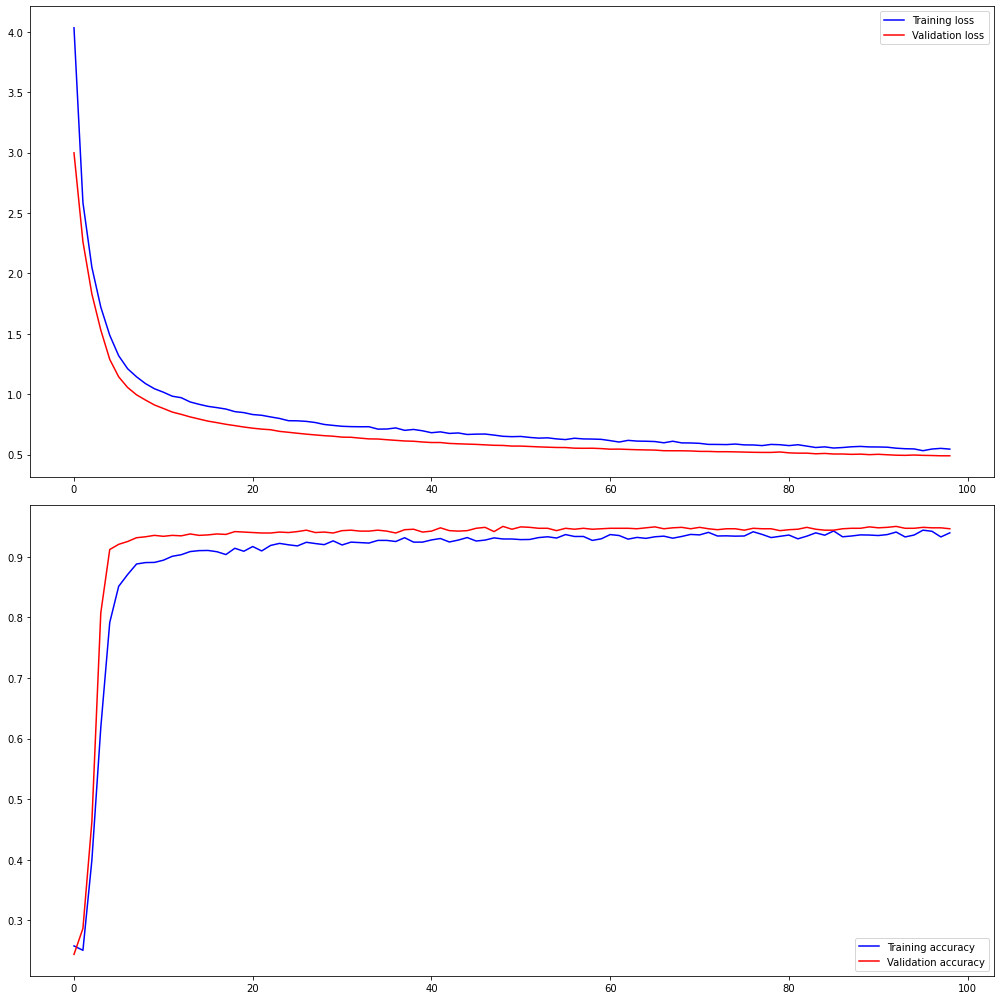

In [31]:
plt.figure(figsize=(14,14))

plt.subplot(2,1,1)
plt.plot(history_3.history['loss'], color='blue', label='Training loss')
plt.plot(history_3.history['val_loss'], color='red', label='Validation loss')
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.plot(history_3.history['accuracy'], color='blue', label='Training accuracy')
plt.plot(history_3.history['val_accuracy'], color='red', label='Validation accuracy')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [32]:
model_3.evaluate(X_test_norm, y_test_hot, verbose=1)

109/109 [==============================] - 0s 91us/step


[0.667113466273754, 0.9357798099517822]

In [33]:
model_4 = Sequential([
    Dense(256, input_shape=(128, ), activation='relu', kernel_initializer='he_normal'),
    Dropout((0.4)),
    Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.05)),
    Dropout((0.5)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.05)),
    Dropout((0.5)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.05)),
    Dense(9, activation='softmax')
])

opt = Adam(learning_rate=0.001)

model_4.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)               

In [34]:
history_4 = model_4.fit(x=X_train_norm, y=y_train_label, batch_size=32, epochs=600, verbose=1,
                        validation_data=(X_val_norm, y_val_label), callbacks=[callbacks])

Train on 3852 samples, validate on 1284 samples
Epoch 1/600
3852/3852 [==============================] - 1s 230us/step - loss: 10.0033 - accuracy: 0.2240 - val_loss: 4.0077 - val_accuracy: 0.2438
Epoch 2/600
3852/3852 [==============================] - 0s 116us/step - loss: 2.7316 - accuracy: 0.3326 - val_loss: 2.0446 - val_accuracy: 0.3606
Epoch 3/600
3852/3852 [==============================] - 0s 115us/step - loss: 1.9335 - accuracy: 0.3624 - val_loss: 1.8081 - val_accuracy: 0.3707
Epoch 4/600
3852/3852 [==============================] - 0s 116us/step - loss: 1.8053 - accuracy: 0.3741 - val_loss: 1.7334 - val_accuracy: 0.3793
Epoch 5/600
3852/3852 [==============================] - 0s 112us/step - loss: 1.7575 - accuracy: 0.3938 - val_loss: 1.7423 - val_accuracy: 0.3668
Epoch 6/600
3852/3852 [==============================] - 0s 111us/step - loss: 1.6897 - accuracy: 0.4164 - val_loss: 1.6115 - val_accuracy: 0.4136
Epoch 7/600
3852/3852 [==============================] - 0s 107us/ste

3852/3852 [==============================] - 0s 112us/step - loss: 1.0034 - accuracy: 0.7461 - val_loss: 0.9337 - val_accuracy: 0.8107
Epoch 57/600
3852/3852 [==============================] - 0s 109us/step - loss: 0.9970 - accuracy: 0.7521 - val_loss: 0.9065 - val_accuracy: 0.8061
Epoch 58/600
3852/3852 [==============================] - 0s 109us/step - loss: 0.9810 - accuracy: 0.7547 - val_loss: 0.9118 - val_accuracy: 0.8084
Epoch 59/600
3852/3852 [==============================] - 0s 110us/step - loss: 0.9831 - accuracy: 0.7516 - val_loss: 0.9035 - val_accuracy: 0.8100
Epoch 60/600
3852/3852 [==============================] - 0s 111us/step - loss: 0.9711 - accuracy: 0.7658 - val_loss: 0.9055 - val_accuracy: 0.8123
Epoch 61/600
3852/3852 [==============================] - 0s 112us/step - loss: 0.9795 - accuracy: 0.7516 - val_loss: 0.8994 - val_accuracy: 0.8069
Epoch 62/600
3852/3852 [==============================] - 1s 131us/step - loss: 0.9717 - accuracy: 0.7622 - val_loss: 0.8889 

3852/3852 [==============================] - 0s 116us/step - loss: 0.6049 - accuracy: 0.9148 - val_loss: 0.6382 - val_accuracy: 0.9291
Epoch 167/600
3852/3852 [==============================] - 0s 116us/step - loss: 0.5928 - accuracy: 0.9177 - val_loss: 0.6334 - val_accuracy: 0.9213
Epoch 168/600
3852/3852 [==============================] - 0s 117us/step - loss: 0.5994 - accuracy: 0.9128 - val_loss: 0.6149 - val_accuracy: 0.9260
Epoch 169/600
3852/3852 [==============================] - 0s 113us/step - loss: 0.6152 - accuracy: 0.9182 - val_loss: 0.6248 - val_accuracy: 0.9237
Epoch 170/600
3852/3852 [==============================] - 0s 117us/step - loss: 0.5977 - accuracy: 0.9195 - val_loss: 0.6235 - val_accuracy: 0.9276
Epoch 171/600
3852/3852 [==============================] - 1s 131us/step - loss: 0.6014 - accuracy: 0.9224 - val_loss: 0.6224 - val_accuracy: 0.9307
Epoch 172/600
3852/3852 [==============================] - 0s 125us/step - loss: 0.5858 - accuracy: 0.9247 - val_loss: 0

3852/3852 [==============================] - 0s 116us/step - loss: 0.5509 - accuracy: 0.9263 - val_loss: 0.5561 - val_accuracy: 0.9354
Epoch 222/600
3852/3852 [==============================] - 0s 116us/step - loss: 0.5210 - accuracy: 0.9317 - val_loss: 0.5771 - val_accuracy: 0.9315
Epoch 223/600
3852/3852 [==============================] - 0s 121us/step - loss: 0.5024 - accuracy: 0.9382 - val_loss: 0.5557 - val_accuracy: 0.9299
Epoch 224/600
3852/3852 [==============================] - 0s 115us/step - loss: 0.5144 - accuracy: 0.9317 - val_loss: 0.5458 - val_accuracy: 0.9346
Epoch 225/600
3852/3852 [==============================] - 0s 117us/step - loss: 0.5209 - accuracy: 0.9307 - val_loss: 0.5591 - val_accuracy: 0.9330
Epoch 226/600
3852/3852 [==============================] - 0s 113us/step - loss: 0.5279 - accuracy: 0.9356 - val_loss: 0.5538 - val_accuracy: 0.9361
Epoch 227/600
3852/3852 [==============================] - 0s 113us/step - loss: 0.5228 - accuracy: 0.9348 - val_loss: 0

Epoch 276/600
3852/3852 [==============================] - 0s 112us/step - loss: 0.4869 - accuracy: 0.9393 - val_loss: 0.5497 - val_accuracy: 0.9361
Epoch 277/600
3852/3852 [==============================] - 0s 114us/step - loss: 0.4855 - accuracy: 0.9411 - val_loss: 0.5370 - val_accuracy: 0.9361
Epoch 278/600
3852/3852 [==============================] - 0s 121us/step - loss: 0.4873 - accuracy: 0.9406 - val_loss: 0.5400 - val_accuracy: 0.9385
Epoch 279/600
3852/3852 [==============================] - 1s 130us/step - loss: 0.5024 - accuracy: 0.9369 - val_loss: 0.5655 - val_accuracy: 0.9346
Epoch 280/600
3852/3852 [==============================] - 0s 119us/step - loss: 0.4970 - accuracy: 0.9385 - val_loss: 0.5405 - val_accuracy: 0.9377
Epoch 281/600
3852/3852 [==============================] - 0s 112us/step - loss: 0.4956 - accuracy: 0.9421 - val_loss: 0.5351 - val_accuracy: 0.9408
Epoch 282/600
3852/3852 [==============================] - 0s 119us/step - loss: 0.4847 - accuracy: 0.9387

Epoch 331/600
3852/3852 [==============================] - 0s 116us/step - loss: 0.4569 - accuracy: 0.9421 - val_loss: 0.5461 - val_accuracy: 0.9377
Epoch 332/600
3852/3852 [==============================] - 0s 117us/step - loss: 0.4612 - accuracy: 0.9444 - val_loss: 0.5280 - val_accuracy: 0.9393
Epoch 333/600
3852/3852 [==============================] - 0s 118us/step - loss: 0.4556 - accuracy: 0.9496 - val_loss: 0.5168 - val_accuracy: 0.9408
Epoch 334/600
3852/3852 [==============================] - 0s 116us/step - loss: 0.4598 - accuracy: 0.9452 - val_loss: 0.5181 - val_accuracy: 0.9400
Epoch 335/600
3852/3852 [==============================] - 0s 115us/step - loss: 0.4559 - accuracy: 0.9468 - val_loss: 0.5293 - val_accuracy: 0.9393
Epoch 336/600
3852/3852 [==============================] - 0s 117us/step - loss: 0.4809 - accuracy: 0.9413 - val_loss: 0.5307 - val_accuracy: 0.9377
Epoch 337/600
3852/3852 [==============================] - 0s 115us/step - loss: 0.4637 - accuracy: 0.9455

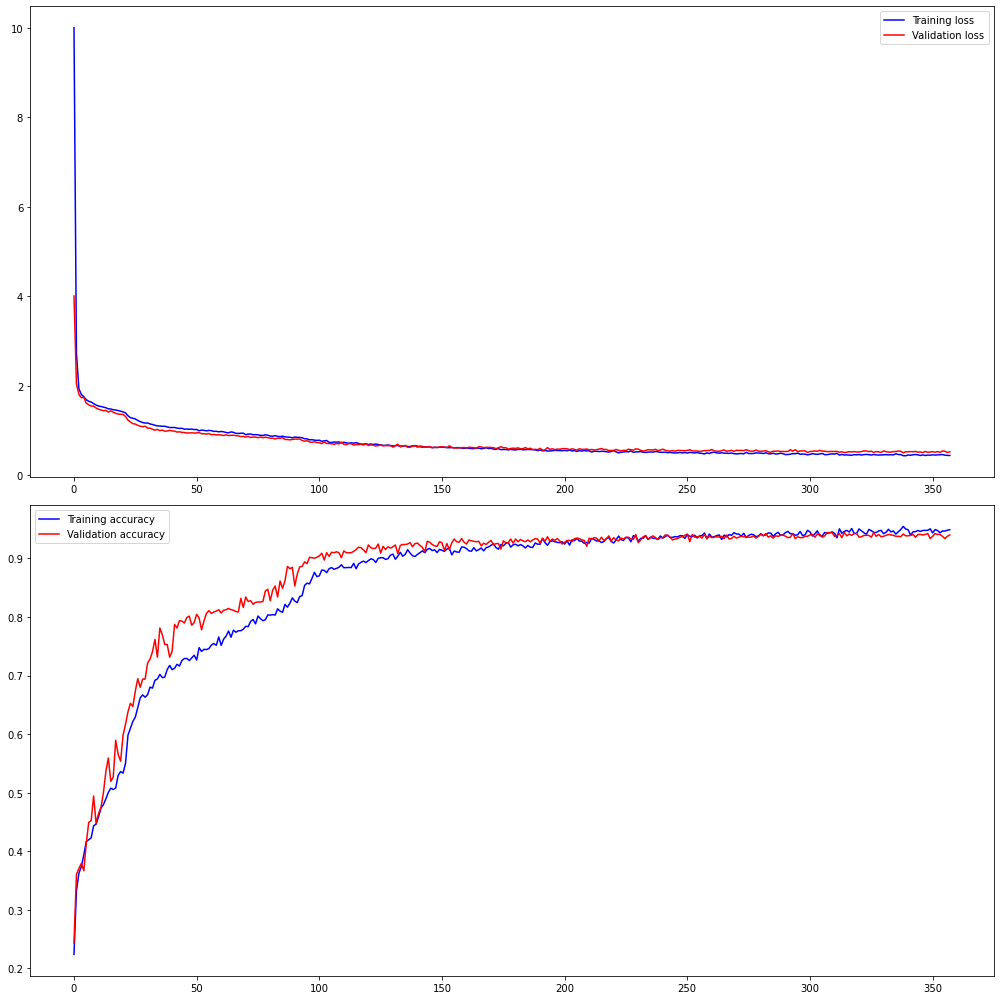

In [35]:
plt.figure(figsize=(14,14))

plt.subplot(2,1,1)
plt.plot(history_4.history['loss'], color='blue', label='Training loss')
plt.plot(history_4.history['val_loss'], color='red', label='Validation loss')
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.plot(history_4.history['accuracy'], color='blue', label='Training accuracy')
plt.plot(history_4.history['val_accuracy'], color='red', label='Validation accuracy')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [36]:
model_4.evaluate(X_test_norm, y_test_label, verbose=1)

109/109 [==============================] - 0s 92us/step


[0.5198459499472872, 0.9449541568756104]

In [83]:
model_5 = Sequential([
    Dense(64, input_shape=(128, ), activation='relu'),    
    Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.03)),
    Dropout((0.2)),
    Dense(256, activation='relu', kernel_initializer='he_normal', activity_regularizer=l2(0.003)),
    Dropout((0.2)),
    Dense(256, activation='relu', kernel_initializer='he_normal', activity_regularizer=l2(0.003)),
    Dropout((0.3)),
    Dense(128, activation='relu', kernel_initializer='he_normal', activity_regularizer=l2(0.002)),
    Dropout((0.2)),
    Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.03)),
    Dense(9, activation='softmax')
])

opt = keras.optimizers.Nadam(learning_rate=0.0025)

model_5.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model_5.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_65 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_38 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_39 (Dropout)         (None, 256)             

In [84]:
history_5 = model_5.fit(X_train_norm, y_train_label, batch_size=32, epochs=400, verbose=1,
                        validation_data=(X_val_norm, y_val_label), callbacks=[callbacks])

Train on 3852 samples, validate on 1284 samples
Epoch 1/400
3852/3852 [==============================] - 1s 290us/step - loss: 5.6694 - accuracy: 0.3258 - val_loss: 2.1784 - val_accuracy: 0.5810
Epoch 2/400
3852/3852 [==============================] - 1s 144us/step - loss: 1.5581 - accuracy: 0.6064 - val_loss: 1.4002 - val_accuracy: 0.6114
Epoch 3/400
3852/3852 [==============================] - 1s 139us/step - loss: 1.1654 - accuracy: 0.7445 - val_loss: 0.9860 - val_accuracy: 0.8076
Epoch 4/400
3852/3852 [==============================] - 1s 141us/step - loss: 0.9865 - accuracy: 0.8178 - val_loss: 0.9000 - val_accuracy: 0.8442
Epoch 5/400
3852/3852 [==============================] - 1s 139us/step - loss: 0.8628 - accuracy: 0.8596 - val_loss: 0.7682 - val_accuracy: 0.8731
Epoch 6/400
3852/3852 [==============================] - 1s 141us/step - loss: 0.7763 - accuracy: 0.8782 - val_loss: 0.7560 - val_accuracy: 0.8676
Epoch 7/400
3852/3852 [==============================] - 1s 135us/step

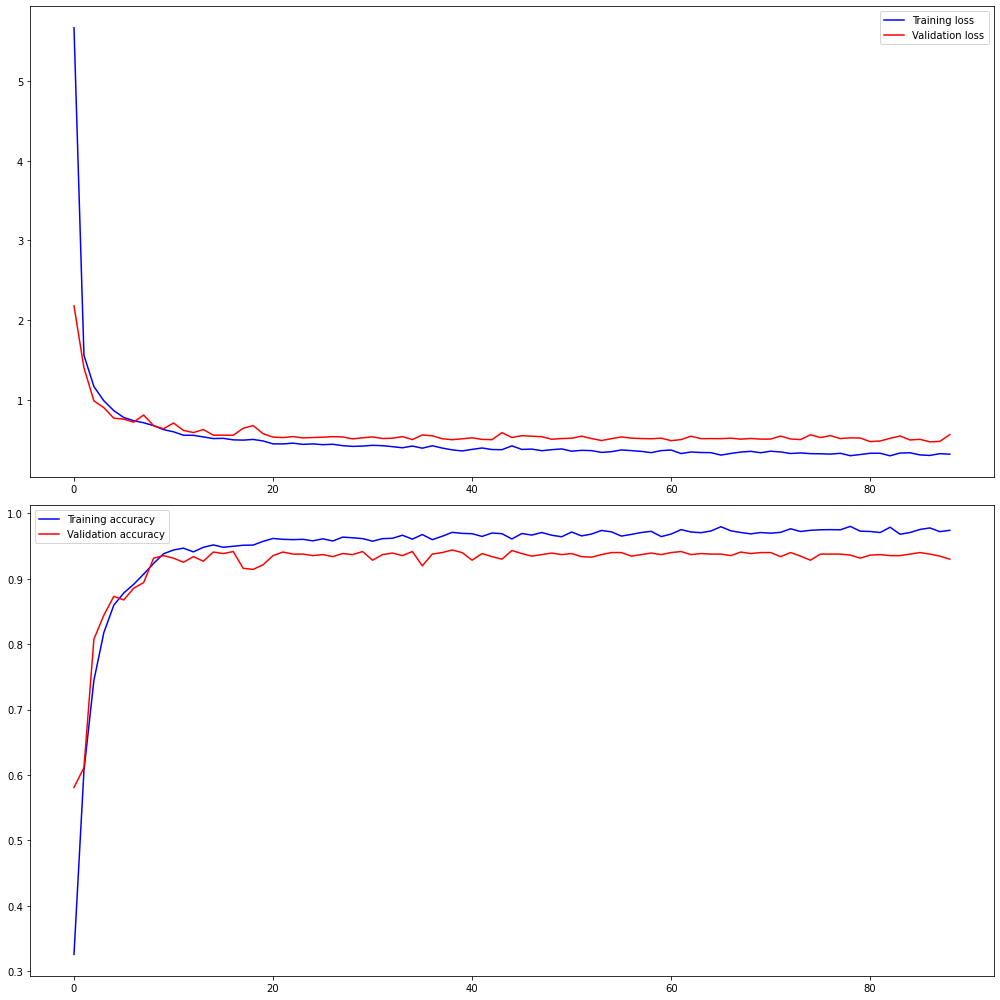

In [85]:
plt.figure(figsize=(14,14))

plt.subplot(2,1,1)
plt.plot(history_5.history['loss'], color='blue', label='Training loss')
plt.plot(history_5.history['val_loss'], color='red', label='Validation loss')
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.plot(history_5.history['accuracy'], color='blue', label='Training accuracy')
plt.plot(history_5.history['val_accuracy'], color='red', label='Validation accuracy')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [86]:
model_5.evaluate(X_test_norm, y_test_label, verbose=1)

109/109 [==============================] - 0s 156us/step


[0.4584391333094431, 0.9541284441947937]

In [87]:
y_pred_5 = model_5.predict_classes(X_test_norm)

In [88]:
y_pred_5.round(2)

array([0, 0, 0, 0, 0, 2, 0, 0, 7, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 8, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 7, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
      dtype=int64)

In [43]:
y_pred_3 = model_3.predict_classes(X_test_norm)
y_pred_3

array([0, 0, 0, 0, 0, 7, 0, 0, 7, 0, 0, 0, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 0, 7, 2, 2, 2, 2, 2, 2, 3, 3, 3, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
      dtype=int64)

In [44]:
y_pred_2 = model_2.predict_classes(X_test_norm)
y_pred_2

array([0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 1, 7, 2, 8, 2, 2, 2, 8, 3, 3, 3, 0, 3, 3, 3, 3,
       3, 3, 3, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 0, 8, 8, 8, 8, 8],
      dtype=int64)

In [45]:
y_pred_4 = model_4.predict_classes(X_test_norm)
y_pred_4

array([0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 7, 2, 3, 2, 2, 2, 2, 3, 3, 3, 8, 3, 3, 3, 3,
       3, 3, 3, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
      dtype=int64)

In [167]:
model_6 = Sequential([
    Dense(64, input_shape=(128, ), activation='relu'),
    Dropout((0.2)),
    Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.03)),
    Dropout((0.2)),
    Dense(256, activation='relu', kernel_initializer='he_normal', activity_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout((0.3)),
    Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.05)),
    Dropout((0.2)),
    BatchNormalization(),
    Dense(9, activation='softmax')
])

opt = keras.optimizers.Adagrad(learning_rate=0.005)

model_6.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model_6.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_155 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_72 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_156 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_73 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_157 (Dense)            (None, 256)               33024     
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_74 (Dropout)         (None, 256)             

In [168]:
history_6 = model_6.fit(X_train_norm, y_train_label, batch_size=16, epochs=400, verbose=1,
                        validation_data=(X_val_norm, y_val_label), callbacks=[callbacks])

Train on 3852 samples, validate on 1284 samples
Epoch 1/400
3852/3852 [==============================] - 2s 459us/step - loss: 9.9181 - accuracy: 0.5906 - val_loss: 8.1130 - val_accuracy: 0.2601
Epoch 2/400
3852/3852 [==============================] - 1s 276us/step - loss: 6.1937 - accuracy: 0.7492 - val_loss: 5.3722 - val_accuracy: 0.8349
Epoch 3/400
3852/3852 [==============================] - 1s 261us/step - loss: 4.6311 - accuracy: 0.7936 - val_loss: 3.8842 - val_accuracy: 0.8980
Epoch 4/400
3852/3852 [==============================] - 1s 257us/step - loss: 3.7359 - accuracy: 0.8204 - val_loss: 3.1276 - val_accuracy: 0.9112
Epoch 5/400
3852/3852 [==============================] - 1s 274us/step - loss: 3.0858 - accuracy: 0.8463 - val_loss: 2.6205 - val_accuracy: 0.9167
Epoch 6/400
3852/3852 [==============================] - 1s 262us/step - loss: 2.6362 - accuracy: 0.8523 - val_loss: 2.2465 - val_accuracy: 0.9167
Epoch 7/400
3852/3852 [==============================] - 1s 264us/step

In [169]:
model_6.evaluate(X_test_norm, y_test_label, verbose=1)

109/109 [==============================] - 0s 270us/step


[0.25291747333259756, 0.9541284441947937]

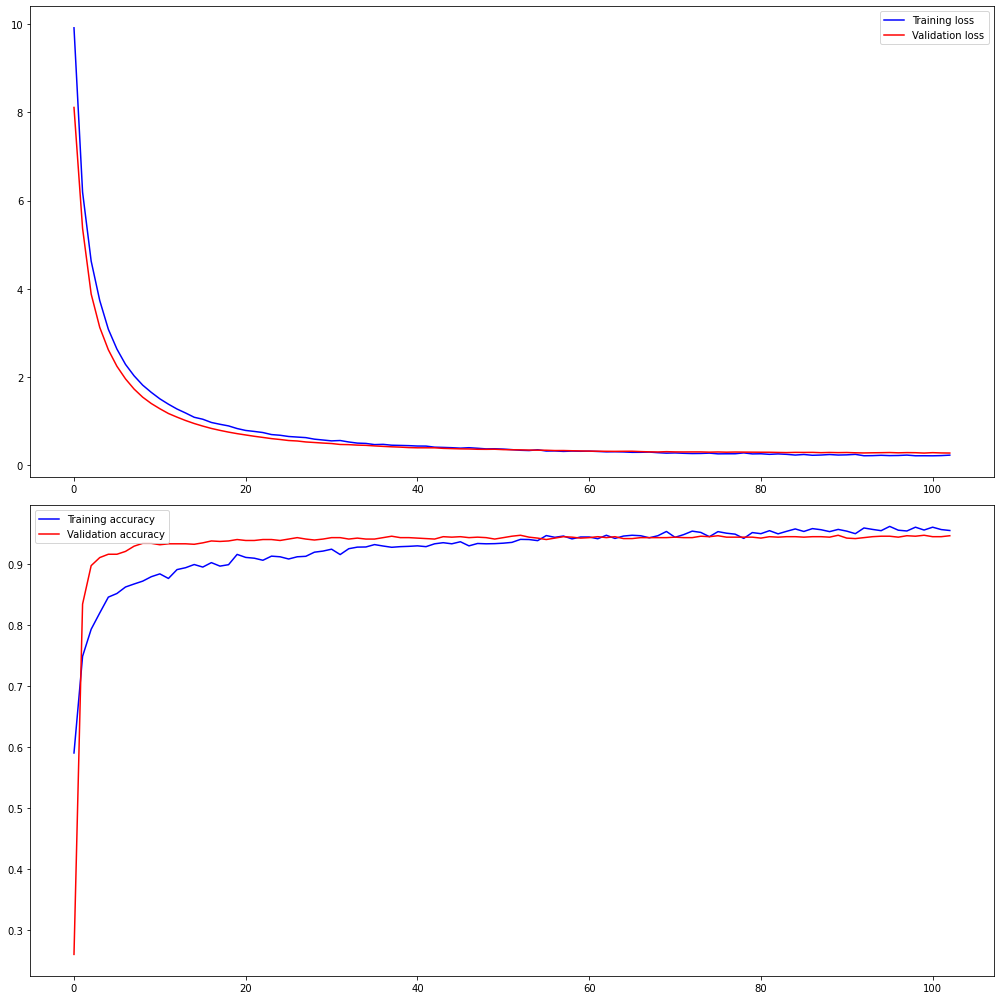

In [170]:
plt.figure(figsize=(14,14))

plt.subplot(2,1,1)
plt.plot(history_6.history['loss'], color='blue', label='Training loss')
plt.plot(history_6.history['val_loss'], color='red', label='Validation loss')
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.plot(history_6.history['accuracy'], color='blue', label='Training accuracy')
plt.plot(history_6.history['val_accuracy'], color='red', label='Validation accuracy')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [171]:
y_pred_6 = model_6.predict_classes(X_test_norm)
y_pred_6

array([0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 7, 2, 7, 2, 2, 2, 2, 3, 3, 3, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
      dtype=int64)